# Kanceláře - parkoviště

Předěláno na GTFS model, protože transmodel nějak nenabízí geometrii

In [ ]:
import requests
from datetime import datetime
import pandas as pd
import polyline
from shapely.geometry import LineString

# funkce vrátí slovník ve struktuře budoucí tabulky. Až na category jsou proměnné dané v konkrétním for cyklu
def create_route_dict (category):
    return {
        "CISLO_ITERACE": iteration_num,
        "KATEGORIE_ITERACE": category,
        "PARKOVISTE": row["PARKOVISTE"],
        "KANCELAR": row["KANCELAR"],
        "DATUM": date,
        "CAS": time + "+01:00",
        "SPICKA": spicka,
        "DOBA": round(iteration['duration']/60),
        "DELKA": round(overall_distance/1000, 1),
        "CAS_ZACATEK": datetime.fromisoformat(iteration['start']).time().isoformat() + "+01:00",
        "CAS_KONEC": datetime.fromisoformat(iteration['end']).time().isoformat() + "+01:00",
        "POCET_USEKU": len(iteration['legs']),
        "POCET_PRESTUPU": transfers,
        "KROKY": modes,
        "LINESTRING_TRASY": overall_linestring,
        "LINESTRINGY_ETAPY": geometry_legs              # geometrie jednotlivých kroků pro případnou vizualizaci
    }

url = "http://localhost:8080/otp/gtfs/v1"
headers = {"Content-Type": "application/json"}

PR_Kancelare = pd.read_csv("DATA/API_zdroje/kancelare_parkoviste.csv")

Dates = ["2025_11_03", "2025_11_04", "2025_11_05", "2025_11_06", "2025_11_07"]
Times = ["5:30", "6:30", "7:30", "17:00"]

# GraphQL query
query = '''query Parking (
        $from_lat: Float!,              # definování proměnných, které se vkládají ve "variables"
        $from_lon: Float!, 
        $to_lat: Float!, 
        $to_lon: Float!,
        $Date: String!
        $Time: String!
        ) 
    {
    plan(
        from: {lat: $from_lat, lon: $from_lon}
        to: {lat: $to_lat, lon: $to_lon}
        date: $Date
        time: $Time                     # třeba zadat UCT (ale vrací to podle skutečné time zone)
        numItineraries: 5               # počet iterací
        transportModes: [               # definice dopravních prostředků
            {mode: WALK},              
            {mode: BUS},               
            {mode: TRAM}, 
            {mode: RAIL}, 
            {mode: SUBWAY}, 
            {mode: TROLLEYBUS}, 
            {mode: FERRY}
        ]
            transferPenalty: 1          # drobná penalta za počet přestupů, ale nevím, jestli to něco dělá
        ) {
            itineraries {
            start                       # datetime, timezone - Prague
            end                         # datetime, timezone - Prague 
            duration                    # in seconds
            legs {
                mode
                route {
                shortName
                }
                distance
                duration
                from {
                name
                }
                to {
                name
                }
                legGeometry { 
                length
                points
                }
            }
            }
        }
        }
'''

routes = []

for date in Dates:
    for time in Times:
        for _, row in PR_Kancelare.iterrows():
            # Rozhodnutí, jestli se jede do kanceláře nebo z kanceláře
            if datetime.strptime(time, "%H:%M").hour < 12:
                from_lat, from_lon = row["PARKOVISTE_Y"], row["PARKOVISTE_X"]
                to_lat, to_lon = row["KANCELAR_X"], row["KANCELAR_Y"]
                spicka = "ranni"
            else:
                from_lat, from_lon = row["KANCELAR_X"], row["KANCELAR_Y"]
                to_lat, to_lon = row["PARKOVISTE_Y"], row["PARKOVISTE_X"]
                spicka = "odpoledni"
            
            # dodání proměnných do query
            payload = {
                "query": query,
                "variables": {
                    "from_lat": float(from_lat),
                    "from_lon": float(from_lon),
                    "to_lat": float(to_lat),
                    "to_lon": float(to_lon),
                    "Date": date,
                    "Time": time
                    },
                "operationName": "Parking"
                }
            
            # volání API
            response = requests.post(url, headers=headers, json=payload, timeout=30)
            data = response.json()

            # pomocné proměnné
            iteration_num = 1 # pořadí iterací, na konci průchodu každé iterace se zvyšuje
            limit_time = 10*60 # 10 min, nastavení limitu pro chůzi z výchozích/do koncových bodů, pro Prahu je to 10 (občas to hází, že  je rychlejší jít 40 min než čekat na dopravní prostředky)
            duration_fast = 24*60*60 # celý den v sekundách, pro porovnávání nejrychlejších tras
            leg_num_low = 30 # pro porovnávání iterací, pro nejmenší počet

            # nebo by se to dalo napsat takto:
            # duration_fast = data['data']['plan']['itineraries'][0]['duration']
            # leg_num_low = len(data['data']['plan']['itineraries'][0]['legs']

            for iteration in data['data']['plan']['itineraries']:
                modes =''
                transports = []
                transfers = 0
                all_coords = [] # seznam všech GPS bodů
                geometry_legs = '' # geometrie jednotlivých kroků + dopravní prostředek
                
                # na začátku a konci je vždy chůze, pro zjistění, jestli nejsou moc dlouhé
                time_walk_start = iteration['legs'][0]['duration']
                time_walk_end = iteration['legs'][-1]['duration']

                
                for i, leg in enumerate(iteration['legs']):
                    # převedení geometrie na GPS body (geometry)
                    coords = polyline.decode(leg["legGeometry"]["points"]) # přepsání hrůzostrašných písmen na lat a lon dvojice
                    coords = [(lon, lat) for lat, lon in coords] # ale protože linestring je lon a lat, tak jen přehození pořadí pro každou dvojici

                    # Chtěla jsem, aby se neopakovaly přestupové body, ale často se liší na poslední číslici
                    if all_coords:
                        if coords[0] == all_coords[-1]:
                            all_coords.extend(coords[:-1])
                        else:
                            all_coords.extend(coords)
                    else:
                        all_coords.extend(coords)

                    # vytvoření stringu itineráře trasy (modes) a stringu linestring jednotlivých kroků                 
                    if i == len(iteration['legs']) - 1: # poslední krok, jen aby na konci nebylo ' +'
                        geometry_legs += f'{leg["mode"]}+{LineString(coords)}'
                        if leg['mode'] == 'WALK': # WALK nemá linku, takže by to házelo chyby
                            modes += f"{leg['mode']}, {round(leg['duration']/60)} min, {leg['distance']} m ({leg['from']['name']} - {leg['to']['name']})"
                        else:
                            modes += f"{leg['mode']}, {round(leg['duration']/60)} min, {leg['distance']} m  ({leg['route']['shortName']}, {leg['from']['name']} - {leg['to']['name']})"
                    else:
                        geometry_legs += f'{leg["mode"]}+{LineString(coords)};'
                        if leg['mode'] == 'WALK':
                            modes += f'{leg['mode']}, {round(leg['duration']/60)} min, {leg['distance']} m ({leg['from']['name']} - {leg['to']['name']}) + '
                        else:
                            modes += f'{leg['mode']}, {round(leg['duration']/60)} min, {leg['distance']} m ({leg['route']['shortName']}, {leg['from']['name']} - {leg['to']['name']}) + '
                
                    # ad geometry_legs - je to připravené na případnou možnost obarvení trasy podle dopravního prostředku
                                # dá se to celkem jednoduše přes split rozdělit na jednotlivé kroky (oddělovač ;) a prostřed + linestring (oddělovač+)

                    # pro vynechání stejných tras, které mají jen jiné čekací doby
                    if leg['mode'] == 'WALK':
                        transports += leg['mode']
                    else:
                        transports += leg['route']['shortName']
                        transfers += 1

                # získání délky celé trasy
                overall_distance = sum(leg['distance'] for leg in iteration['legs'])
                overall_linestring = LineString(all_coords)

                # rozhodovací bloky - rozdělení na nejrychlejší a s nejméně přestupy
                if int(iteration['duration']) < duration_fast:
                    duration_fast = int(iteration['duration'])
                    fast_transports = transports
                    fast_route = create_route_dict('nejrychlejsi')

                # tady je to jedno, ale v případě obcí je třeba ošetřit cestu na vlak (ta může být delší a pak se to dá oseknout)
                if len(iteration['legs']) < leg_num_low and len(iteration['legs']) > 2:
                    # počet kroků, kde je více než 2 vynechá iterace, kde je jen chůze
                    if time_walk_start <= limit_time and time_walk_end <= limit_time: 
                        # omezení na to, aby chůze na začátku nebo na konci nebyla delší než je stanovený limit, plus tady je to důležitý jen aby se pojistilo, že nejméně přestupů je skutečně u nejrychlejší trasy. Větší smysl to bude u obcí, kde je větší šance, že rychlý čas je kvůli velkému počtu přestupů. Ale kdyby tady celý blok nebyl, vůbec se nic nestane
                        # leg_low_transports = transports - bude to třeba v případě 
                        leg_num_low = len(iteration['legs'])
                        leg_low_route = create_route_dict('nejmene prestupu')

                iteration_num += 1

            if fast_route['POCET_USEKU'] == leg_low_route['POCET_USEKU']: 
                routes.append(fast_route)
            else:
                routes.append(fast_route)
                routes.append(leg_low_route)

routes = pd.DataFrame(routes)
routes.to_csv("DATA_HD/trasy_PR_kancelare.csv", sep=';', na_rep='', index= False)



In [80]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# načtení CSV
df = pd.read_csv("DATA_HD/trasy_PR_kancelare.csv", sep=";", encoding="cp1250")

# převod WKT na geometrii
df["LINESTRING_TRASY"] = df["LINESTRING_TRASY"].apply(wkt.loads)

# vytvoření GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="LINESTRING_TRASY", crs="EPSG:4326")

# uložení jako shapefile
gdf.to_file("DATA_HD/trasy_PR_kancelare.shp", driver="ESRI Shapefile", encoding="utf-8")

C:\Users\Lucys\AppData\Local\Temp\ipykernel_37948\2268579590.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("DATA_HD/trasy_PR_kancelare.shp", driver="ESRI Shapefile", encoding="utf-8")
c:\Users\Lucys\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CISLO_ITERACE' to 'CISLO_ITER'
  ogr_write(
c:\Users\Lucys\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'KATEGORIE_ITERACE' to 'KATEGORIE_'
  ogr_write(
c:\Users\Lucys\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CAS_ZACATEK' to 'CAS_ZACATE'
  ogr_write(
c:\Users\Lucys\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POCET_USEKU' to 'POCET_USEK'
  ogr_

In [24]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
df = pd.read_csv("DATA_HD/trasy_PR_kancelare.csv", sep=";", encoding="cp1250")
# převod WKT na geometrii
df["LINESTRING_TRASY"] = df["LINESTRING_TRASY"].apply(wkt.loads)

# vytvoření GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="LINESTRING_TRASY")

gdf.to_file("DATA_HD/trasy_PR_kancelare.geojson")
# gdf.to_file("DATA_HD/trasy_PR_kancelare.geojson", geometry="LINESTRING_TRASY")

c:\Users\Lucys\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [82]:
print(gdf.geom_type.unique())

['LineString']


# Zkušební kódy

In [41]:
duration_fast = data['data']['plan']['itineraries'][0]['duration']
duration_fast
leg_num_low = len(data['data']['plan']['itineraries'][0]['legs'])
leg_num_low

5

In [26]:
# jaká je trasa ke geometrii?

data['data']['plan']['itineraries'][0]['legs'][0]['legGeometry']['points']



'm~mpHarfwA@XWNBd@Bl@EFHpA@XLzBOBODAQAGE?'

In [25]:
# převod geometrie - jednotlivé kroky

import pandas as pd
import polyline
import geopandas as gpd
from shapely.geometry import LineString

rows = []
for leg in data['data']['plan']['itineraries'][0]["legs"]:
    coords = polyline.decode(leg["legGeometry"]["points"])
    line = LineString([(lon, lat) for lat, lon in coords])
    rows.append({
        "mode": leg["mode"],
        "geometry": line
    })

gdf = gpd.GeoDataFrame(rows, crs="EPSG:4326")
gdf

,mode,geometry
0,WALK,"LINESTRING (14.45681 50.04791, 14.45668 50.047..."
1,BUS,"LINESTRING (14.45506 50.04808, 14.4534 50.0478..."
2,WALK,"LINESTRING (14.44759 50.04476, 14.44761 50.044..."
3,SUBWAY,"LINESTRING (14.44876 50.04442, 14.44874 50.044..."
4,WALK,"LINESTRING (14.51627 50.12415, 14.51628 50.124..."


In [37]:
# převod geometrie do jednoho linestringu
import polyline
from shapely.geometry import LineString

encoded = data['data']['plan']['itineraries'][0]['legs'][0]['legGeometry']['points']

coords = polyline.decode(encoded)
line = LineString([(lon, lat) for lat, lon in coords])

print(coords)
line.wkt

[(50.04791, 14.45681), (50.0479, 14.45668), (50.04802, 14.4566), (50.048, 14.45641), (50.04798, 14.45618), (50.04801, 14.45614), (50.04796, 14.45573), (50.04795, 14.4556), (50.04788, 14.45498), (50.04796, 14.45496), (50.04804, 14.45493), (50.04805, 14.45502), (50.04806, 14.45506), (50.04809, 14.45506)]


'LINESTRING (14.45681 50.04791, 14.45668 50.0479, 14.4566 50.04802, 14.45641 50.048, 14.45618 50.04798, 14.45614 50.04801, 14.45573 50.04796, 14.4556 50.04795, 14.45498 50.04788, 14.45496 50.04796, 14.45493 50.04804, 14.45502 50.04805, 14.45506 50.04806, 14.45506 50.04809)'

In [7]:
data['data']['plan']['itineraries'][0]["legs"][0]['legGeometry']['length']

14

747


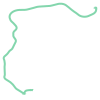

In [15]:
all_coords = []
delka = 0
for leg in data['data']['plan']['itineraries'][0]["legs"]:
    delka += leg['legGeometry']['length']
    coords = polyline.decode(leg["legGeometry"]["points"])
    coords = [(lon, lat) for lat, lon in coords]
    all_coords.extend(coords)

line = LineString(all_coords)
print(delka)
len(all_coords)
line